# Transfer Learning

A Convolutional Neural Network (CNN) for image classification is made up of multiple layers that extract features, such as edges, corners, etc; and then use a final fully-connected layer to classify objects based on these features. You can visualize this like this:

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Fully Connected Layer</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Feature Extraction</td><td style='border: 1px solid black; text-align:center;'>Classification</td></tr>
</table>

*Transfer Learning* is a technique where you can take an existing trained model and re-use its feature extraction layers, replacing its final classification layer with a fully-connected layer trained on your own custom images. With this technique, your model benefits from the feature extraction training that was performed on the base model (which may have been based on a larger training dataset than you have access to) to build a classification model for your own specific set of object classes.

How does this help? Well, think of it this way. Suppose you take a professional tennis player and a complete beginner, and try to teach them both how to play raquetball. It's reasonable to assume that the professional tennis player will be easier to train, because many of the underlying skills involved in raquetball are already learned. Similarly, a pre-trained CNN model may be easier to train to classify specific set of objects because it's already learned how to identify the features of common objects, such as edges and corners. Fundamentally, a pre-trained model can be a great way to produce an effective classifier even when you have limited data with which to train it.

In this notebook, we'll see how to implement transfer learning for a classification model using PyTorch.

## Install and import libraries

First, let's install and import the PyTorch libraries we're going to use.

!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [9]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.8.1


## Prepare the base model

To use transfer learning, we need a base model from which we can use the trained feature extraction layers. The ***resnet*** model is an CNN-based image classifier that has been pre-trained using a huge dataset containing a large number of images of 1000 classes of object, so let's download it and take a look at its layers.

In [10]:
# Load the model (download if not already present)
model = models.resnet34(pretrained=True)

print(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/thiagocarvalho/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100.0%
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

## Prepare the image data

The pretrained model has many layers, starting with a convolutional layer that starts the feature extraction process from image data, and ending with a fully-connected linear layer that maps the extracted features to 1000 class labels.

For feature extraction to work with our own images, we  need to ensure that the image data we use to train our prediction layer has the same number of features (pixel values) as the images originally used to train the feaure extraction layers. The model does not explicitly give this size, but the first convolutional layer applies by a 7x7 kernel with a stride of 2x2 and results in 64 feature values, so the original size must be 64 x (7 &div; 2), which is 224.

PyTorch includes functions for loading and transforming data. We'll use these to create an iterative loader for training data, and a second iterative loader for test data (which we'll use to validate the trained model). The loaders will transform the image data to match the format used to train the original resnet CNN model, convert the image data into *tensors* (which are the core data structure used in PyTorch), and normalize them.

Run the following cell to define the data loaders and list the classes for our images.

In [11]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    
    # Resize to 256 x 256, then center-crop to 224x224 (to match the resnet image size)
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Split into training (70%) and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 30-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 30-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Now load the images from the shapes folder
import os  
data_path = 'data/shapes/'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print('class names:', classes)

class names: ['circle', 'square', 'triangle']


## Create a prediction layer

We downloaded the complete *resnet* model including its final **fc** linear layer. This fully-connected linear layer takes 512 inputs (the extracted features) and produces 1000 outputs (class predictions based on the original training image classes). We need to replace this layer with one that takes the same number of inputs (so we can use the same number of extracted features), but produces a prediction for each of our image classes.

We also need to freeze the feature extraction layers to retain the trained weights. Then when we train the model using our images, only the final prediction layer will learn new weight and bias values - the pre-trained weights already learned for feature extraction will remain the same.

In [13]:
# Set the existing feature extraction layers to read-only
for param in model.parameters():
    param.requires_grad = False

# Replace the prediction layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

# Now print the full model, which will include the feature extraction layers of the base model and our prediction layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

With the layers of the CNN defined, we're ready to train it using our image data. The weights used in the feature extraction layers from the base resnet model will not be changed by training, only the final linear layer that maps the features to our shape classes will be trained.

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 3 epochs (in a real scenario, you'd likely use many more)
epochs = 3
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/840 (0%)] Loss: 1.095517
Training set [300/840 (36%)] Loss: 0.089861
Training set [600/840 (71%)] Loss: 0.024868
Training set: Average loss: 0.194651
Validation set: Average loss: 0.023575, Accuracy: 359/360 (100%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.020895
Training set [300/840 (36%)] Loss: 0.021259
Training set [600/840 (71%)] Loss: 0.012250
Training set: Average loss: 0.020048
Validation set: Average loss: 0.014223, Accuracy: 359/360 (100%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.012438
Training set [300/840 (36%)] Loss: 0.014495
Training set [600/840 (71%)] Loss: 0.009450
Training set: Average loss: 0.013908
Validation set: Average loss: 0.011190, Accuracy: 360/360 (100%)



## View the loss history

We tracked average training and validation loss for each epoch. We can plot these to verify that the loss reduced over the training process and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

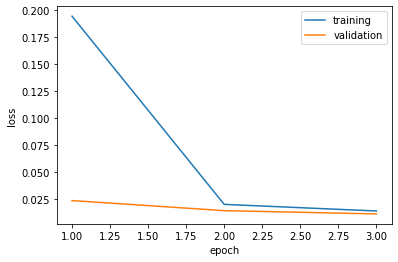

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Evaluate model performance

We can see the final accuracy based on the test data, but typically we'll want to explore performance metrics in a little more depth. Let's plot a confusion matrix to see how well the model is predicting each class.

Getting predictions from test set...


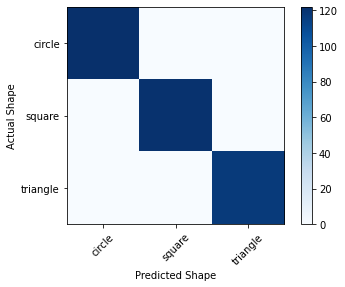

In [16]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Use the trained model

Now that we've trained the model, we can use it to predict the class of an image.

triangle


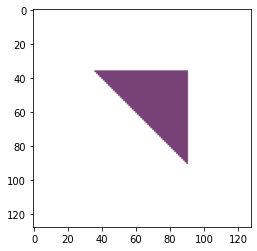

In [17]:
# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return img
    
# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Now let's try it with a new image
from random import randint
from PIL import Image
import os, shutil

# Create a random test image
shape = classes[randint(0, len(classes)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.imshow(img)


index = predict_image(model, img)
print(classes[index])

## Learn more

* [PyTorch Documentation](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)